<a href="https://colab.research.google.com/github/Rachelorange/Lamas-Survey/blob/main/Survey_Model_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

הקובץ נטען בהצלחה...
כמות שורות: 196
כמות עמודות: 28


שורות מקוריות: 196
שורות אחרי סינון קטגוריות: 149

 @@@ Model Training @@@

Training RandomForest...
  Test Accuracy: 0.8333
  Cross-validation Mean Accuracy: 0.8156 (std: 0.0410)

Training GradientBoosting...
  Test Accuracy: 0.8667
  Cross-validation Mean Accuracy: 0.8409 (std: 0.0922)

Training LogisticRegression...
  Test Accuracy: 0.8667
  Cross-validation Mean Accuracy: 0.8493 (std: 0.0670)

Training XGBoost...
  Test Accuracy: 0.9000
  Cross-validation Mean Accuracy: 0.8156 (std: 0.0410)

 **** Best model selected: LogisticRegression ****

Classification Report:
              precision    recall  f1-score   support

      2120.0       1.00      1.00      1.00         1
      2131.0       1.00      1.00      1.00         1
      2342.0       0.00      0.00      0.00         1
      2511.0       1.00      1.00      1.00         1
      2512.0       0.67      1.00      0.80         2
      2514.0       1.00      1.00      1.00 

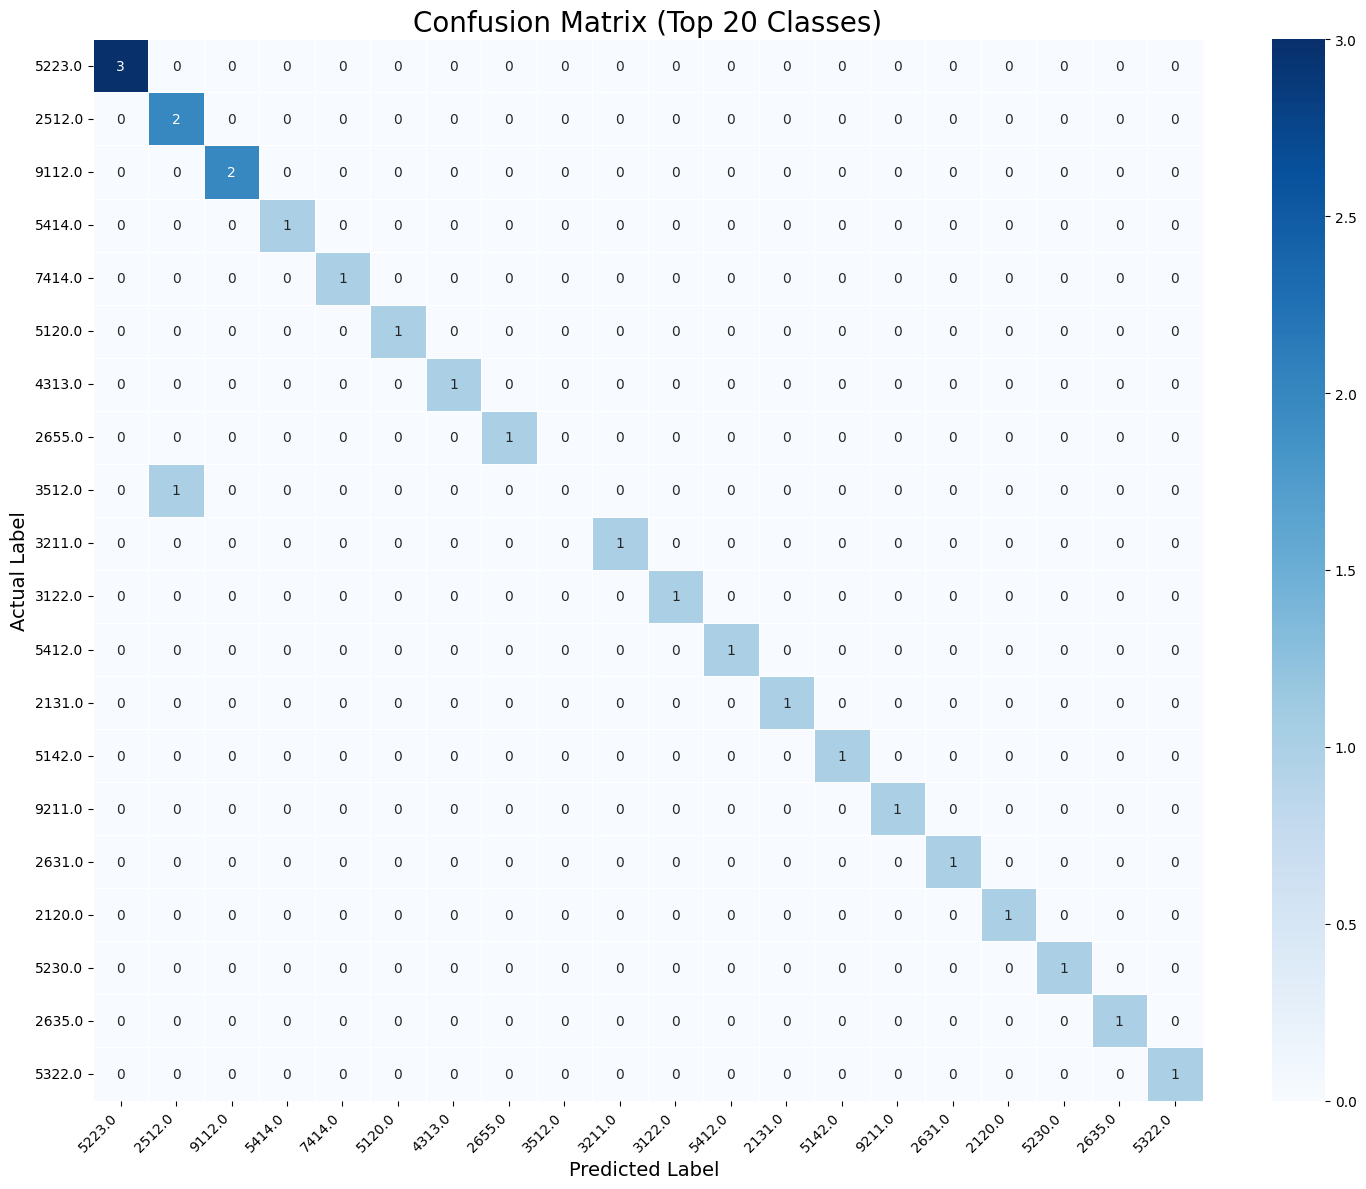

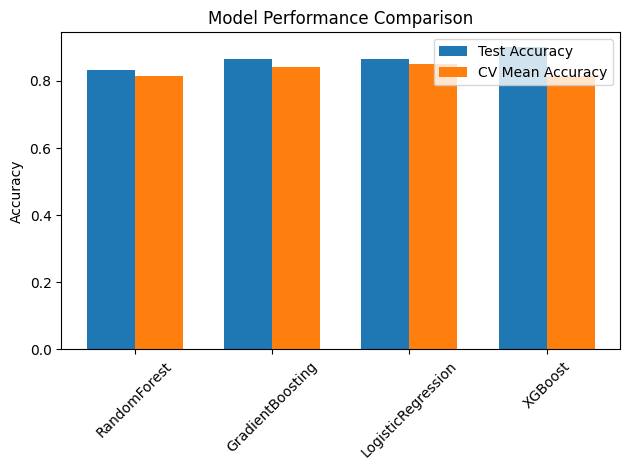


 @@@ Performance Tuning for LogisticRegression @@@
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters found:  {'classifier__C': 10.0, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best accuracy during tuning:  0.8487179487179487

=== Feature Coefficients for LogisticRegression ===
Top 20 most important features:
                feature  importance
1            shnotlimud    0.887969
0                   Gil    0.859338
6   industry_category_4    0.710209
2   industry_category_0    0.691714
35     vetek_Category_3    0.674851
25         TeudaGvoha_4    0.663189
5   industry_category_3    0.643813
33     vetek_Category_1    0.618835
30       Gil_Category_2    0.612535
18      MakorSachar_1.0    0.604772
32     vetek_Category_0    0.597012
24         TeudaGvoha_3    0.539732
19      MakorSachar_2.0    0.486047
4   industry_category_2    0.461476
26         TeudaGvoha_5    0.449200
9   industry_category_7    0.408993
29  

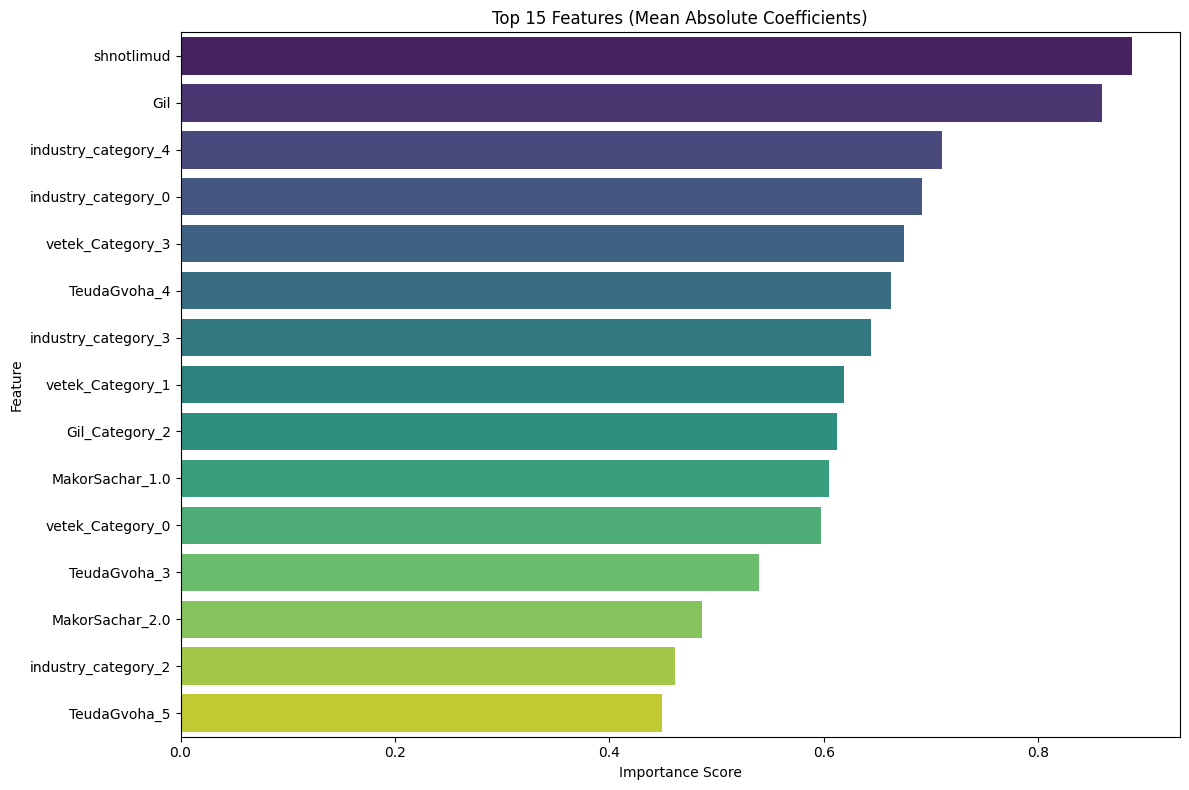


 המודל נשמר בהצלחה !!! 

 5 דומאות לחיזוי:
Sample #1: 2120.0
Sample #2: 3512.0
Sample #3: 5414.0
Sample #4: 5322.0
Sample #5: 5412.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
target_column_name = 'SemelMishlachSofi'

def load_data():
    file_path = 'Survey_File_Part1.xlsx'

    try:
        survey_df = pd.read_excel(file_path, sheet_name='Survey New ds')
        print('הקובץ נטען בהצלחה...')
        print(f"כמות שורות: {len(survey_df)}")
        print(f"כמות עמודות: {len(survey_df.columns)}")
        print("\n")

        return survey_df

    except FileNotFoundError:
        print(f"שגיאה: הקובץ '{file_path}' לא נמצא.")
        return None
    except Exception as e:
        print(f"אירעה שגיאה בטעינת הקובץ: {e}")
        return None


def filter_data(df):

    # איתור וסינון קבוצות עם פחות מ4 מקרים פר משתנה המטרה
    class_counts = df[target_column_name].value_counts()
    rare_classes = class_counts[class_counts < 3].index
    df_filtered = df[~df[target_column_name].isin(rare_classes)]

    # סינון קודים מספריים בלבד
    is_numeric_mask = pd.to_numeric(df_filtered[target_column_name], errors='coerce').notna()
    df_filtered = df_filtered[is_numeric_mask]

    print(f"שורות מקוריות: {len(df)}")
    print(f"שורות אחרי סינון קטגוריות: {len(df_filtered)}")

    return df_filtered


def prepare_data(df):

    numeric_features = ['Gil', 'shnotlimud']
    categorical_features = ['industry_category', 'management_category', 'MaamadAvoda', 'MakorSachar',
                        'TeudaGvoha', 'Gil_Category', 'vetek_Category'] # MaamadAvoda_category, TeudaGvoha_category

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ])

    feature_cols = numeric_features + categorical_features
    X = df[feature_cols].copy()
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[target_column_name].astype(str))

    # טיפול בערכים חסרים
    for col in numeric_features:
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X[col].fillna(X[col].median(), inplace=True) # חציון

    for col in categorical_features:
        X[col].fillna(-1, inplace=True) # לא ידוע = 1-

    return X, y, preprocessor, label_encoder


def train_models(X, y, preprocessor, models_to_test):

    print("\n @@@ Model Training @@@")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    results = {}

    for name, model in models_to_test.items():
        print(f"\nTraining {name}...")
        pipeline = Pipeline([('preprocessor', preprocessor),('classifier', model)])

        # אימון
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

        results[name] = {
            'model': pipeline,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }

        print(f"  Test Accuracy: {accuracy:.4f}")
        print(f"  Cross-validation Mean Accuracy: {cv_scores.mean():.4f} (std: {cv_scores.std():.4f})")

    # בחירת המודל הטוב ביותר
    best_model_name = max(results, key=lambda name: results[name]['cv_mean'])
    print(f"\n **** Best model selected: {best_model_name} ****")

    return results, X_train, X_test, y_train, y_test


def check_perfomance_model(results, best_model_name, y_test, label_encoder):

    y_pred = results[best_model_name]['predictions']
    print("\nClassification Report:")
    target_names = label_encoder.classes_
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion Matrix
    all_class_names = label_encoder.classes_
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(all_class_names)))
    cm_df = pd.DataFrame(cm, index=all_class_names, columns=all_class_names)
    # הצג 20 קטגוריות הנפוצות ביותר
    top_classes_indices = pd.Series(y_test).value_counts().head(20).index
    top_class_names = label_encoder.inverse_transform(top_classes_indices)
    cm_filtered = cm_df.loc[top_class_names, top_class_names]

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_filtered,
                annot=True,
                fmt='d',
                cmap='Blues',
                linewidths=.5)
    plt.title('Confusion Matrix (Top 20 Classes)', fontsize=20)
    plt.ylabel('Actual Label', fontsize=14)
    plt.xlabel('Predicted Label ', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Model Performance Comparison
    model_names = list(results.keys())
    accuracies = [res['accuracy'] for res in results.values()]
    cv_means = [res['cv_mean'] for res in results.values()]

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width / 2, accuracies, width, label='Test Accuracy')
    plt.bar(x + width / 2, cv_means, width, label='CV Mean Accuracy')

    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, preprocessor):
    try:
        cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
        num_features = model.named_steps['preprocessor'].transformers_[0][2]
        feature_names = np.concatenate([num_features, cat_features])
    except Exception as e:
        print(f"Could not get feature names: {e}")
        return

    classifier = model.named_steps['classifier']

    # בדיקה אם למודל יש מאפיין 'feature_importances_' (כמו RandomForest, XGBoost)
    if hasattr(classifier, 'feature_importances_'):
        print(f"\n=== Feature Importances for {classifier.__class__.__name__} ===")
        importances = classifier.feature_importances_
        importance_title = 'Feature Importance'

    # אחרת, בדיקה אם יש לו מאפיין 'coef_' (כמו LogisticRegression)
    elif hasattr(classifier, 'coef_'):
        print(f"\n=== Feature Coefficients for {classifier.__class__.__name__} ===")
        importances = np.mean(np.abs(classifier.coef_), axis=0)
        importance_title = 'Mean Absolute Coefficients'
    else:
        print(f"\n{classifier.__class__.__name__} does not support standard feature importance or coefficients.")
        return

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("Top 20 most important features:")
    print(importance_df.head(20))

    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Top 15 Features ({importance_title})')
    plt.tight_layout()
    plt.show()


def perform_tuning(model_name, models, preprocessor, X_train, y_train):

    print(f"\n @@@ Performance Tuning for {model_name} @@@")

    # הגדרת פרמטרים עבור כל מודל
    param_grids = {
        'RandomForest': {
            'classifier__n_estimators': [150, 250],
            'classifier__max_depth': [15, 25],
            'classifier__min_samples_leaf': [2, 4]
        },
        'XGBoost': {
            'classifier__n_estimators': [150, 250],
            'classifier__max_depth': [5, 8],
            'classifier__learning_rate': [0.05, 0.1]
        },
        'GradientBoosting': {
            'classifier__n_estimators': [150, 250],
            'classifier__max_depth': [8, 10],
            'classifier__learning_rate': [0.05, 0.1]
        },
        'LogisticRegression': {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__solver': ['saga'],
            'classifier__max_iter': [2000]
        }
    }

    base_model = models[model_name]
    grid_to_search = param_grids[model_name]
    pipeline_for_tuning = Pipeline([('preprocessor', preprocessor), ('classifier', base_model)])
    grid_search = GridSearchCV(pipeline_for_tuning,
                               param_grid=grid_to_search,
                               cv=3,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2)
    grid_search.fit(X_train, y_train)

    print("\nBest parameters found: ", grid_search.best_params_)
    print("Best accuracy during tuning: ", grid_search.best_score_)

    best_tuned_model = grid_search.best_estimator_

    return best_tuned_model


def predict(model, df, label_encoder):

    predictions_encoded = model.predict(df)
    predictions = label_encoder.inverse_transform(predictions_encoded) # הורדת הקידוד

    # probabilities = model.predict_proba(df)
    # # מעבר על כל שורה  שקיבלנו לחיזוי
    # for i, single_sample_probs in enumerate(probabilities):
    #     print("-" * 30)
    #     print(f"Sample #{i + 1} --> Primary Prediction: {predictions_decoded[i]}")
    #
    #     # מציאת 5 האינדקסים עם ההסתברות הגבוהה ביותר עבור הדגימה הנוכחית
    #     # np.argsort מחזיר את האינדקסים מהנמוך לגבוה, לכן ניקח את 5 האחרונים ונהפוך את הסדר
    #     top_5_indices = np.argsort(single_sample_probs)[-5:][::-1]
    #
    #     print("Top 5 Most Likely Predictions:")
    #     for index in top_5_indices:
    #         class_name = label_encoder.inverse_transform([model.classes_[index]])[0]
    #         probability = single_sample_probs[index]
    #         print(f"  {class_name}: {probability:.4f}")
    #     print("-" * 30)

    return predictions

def main():

    # טעינת קובץ
    df = load_data()

    # פילטור רשומות ללא משתנה מטרה, או עם קבוצות של עד 3 מקרים בלבד
    df = filter_data(df)

    # הכנת הdata
    X, y, preprocessor, label_encoder = prepare_data(df)

    # אימון מודלים
    models_to_test = {
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
                                               random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=150, max_depth=8, learning_rate=0.1,
                                                       min_samples_split=5, random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
        'XGBoost': xgb.XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.1, use_label_encoder=False,
                                     eval_metric='mlogloss', random_state=42, n_jobs=-1)
    }

    results, X_train, X_test, y_train, y_test = train_models(X, y, preprocessor, models_to_test)

    # בדיקות מודל הטוב ביותר
    best_model_name = max(results, key=lambda name: results[name]['cv_mean'])

    check_perfomance_model(results, best_model_name, y_test, label_encoder)

    #  Perfomance Tuning - ניתן לבצע לפני בחירת המודל הטוב ביותר אם אין מגבלת משאבי מחשב
    final_tuned_model = perform_tuning(best_model_name, models_to_test, preprocessor, X_train, y_train)

    plot_feature_importance(final_tuned_model, preprocessor)

    # שמירת המודל הטוב ביותר
    joblib.dump(final_tuned_model, 'my_best_survey_model.pkl')
    print(f"\n המודל נשמר בהצלחה !!! ")

    # בשביל דוגמא למימוש הניבוי - לקחתי את אותו קובץ
    final_predictions = predict(final_tuned_model, X, label_encoder)
    print("\n 5 דומאות לחיזוי:")
    for i, prediction in enumerate(final_predictions[:5]):
        print(f"Sample #{i + 1}: {prediction}")


if __name__ == "__main__":
    main()
